# 자전거 배치 및 운영 전략 최적화 : 수요 예측 모델 개발

[목차]

1. 개요
    - 배경
    - 분석 목적
    - 분석 목표
    - 데이터 설명
    - 라이브러리 호출

2. EDA
    - 기술통계분석 및 데이터 확인
    - 상관관계 확인
    - 시계열분석
    - 변수별 분석
    
3. Feature Engineering    
    - 결측값 처리
    - 중복값 처리
    - Feature 생성 및 선별
    - 이상치 처리
    - 표준화
    
3. 예측 모델 개발
    - 다중 선형 회귀
    - 다중 선형 회귀(Lasso, Ridge)
    - 다항회귀(Lasso)
    - 다항회귀(Ridge)
    - 랜덤포레스트
    - XGboost
5. 결론

---
---

## 개요

### 1) 배경
- 자전거 대여 시스템의 운영 담당자로, 최적화된 자전거 배치 및 운영 전략을 기획하여 사용자 만족도를 제고시키고 시스템의 효율성을 증가시키는 것이 요구됨

### 2) 분석 목적
- 자전거 대여 패턴을 분석하여 자전거 배치 및 운영 전략을 최적화하고, 대여 수요를 정확히 예측하여 대여 시스템의 효율성을 높이고 사용자 만족도를 증가시키기 위함

### 3) 분석 목표
- 다양한 머신러닝 모델과 전략을 실험하여 가장 정확한 수요 예측 모델을 개발

- 모델의 핵심 평가 지표인 RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추는 것

### 4) 데이터 설명

| 컬럼명       | 데이터 타입 | 설명                                           |
|-------------|------------|----------------------------------------------|
| datetime    | datetime   | 자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00 |
| season      | int        | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)      |
| holiday     | int        | 공휴일 여부 (0: 평일, 1: 공휴일)              |
| workingday  | int        | 근무일 여부 (0: 주말/공휴일, 1: 근무일)       |
| weather     | int        | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| temp        | float      | 실측 온도 (섭씨)                              |
| atemp       | float      | 체감 온도 (섭씨)                              |
| humidity    | int        | 습도 (%)                                      |
| windspeed   | float      | 풍속 (m/s)                                   |
| casual      | int        | 등록되지 않은 사용자의 대여 수                |
| registered  | int        | 등록된 사용자의 대여 수                      |
| count       | int        | 총 대여 수 (종속 변수)                        |

### 5) 라이브러리 호출 및 데이터 프레임 생성

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder


from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [197]:
# train 데이터 셋 호출
train_df = pd.read_csv('./data/train.csv')
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [198]:
# test 데이터 셋 호출
test_df = pd.read_csv('./data/test.csv')
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


---

## EDA

#### 1) 기술통계분석 및 데이터 확인

> #### train 데이터

In [199]:
train_df.shape

(10886, 12)

In [200]:
# 기술 통계 확인
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- 변수간 스케일 차이 존재 => Feature Scaling 작업 요구됨

In [201]:
# 컬럼별 정보 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


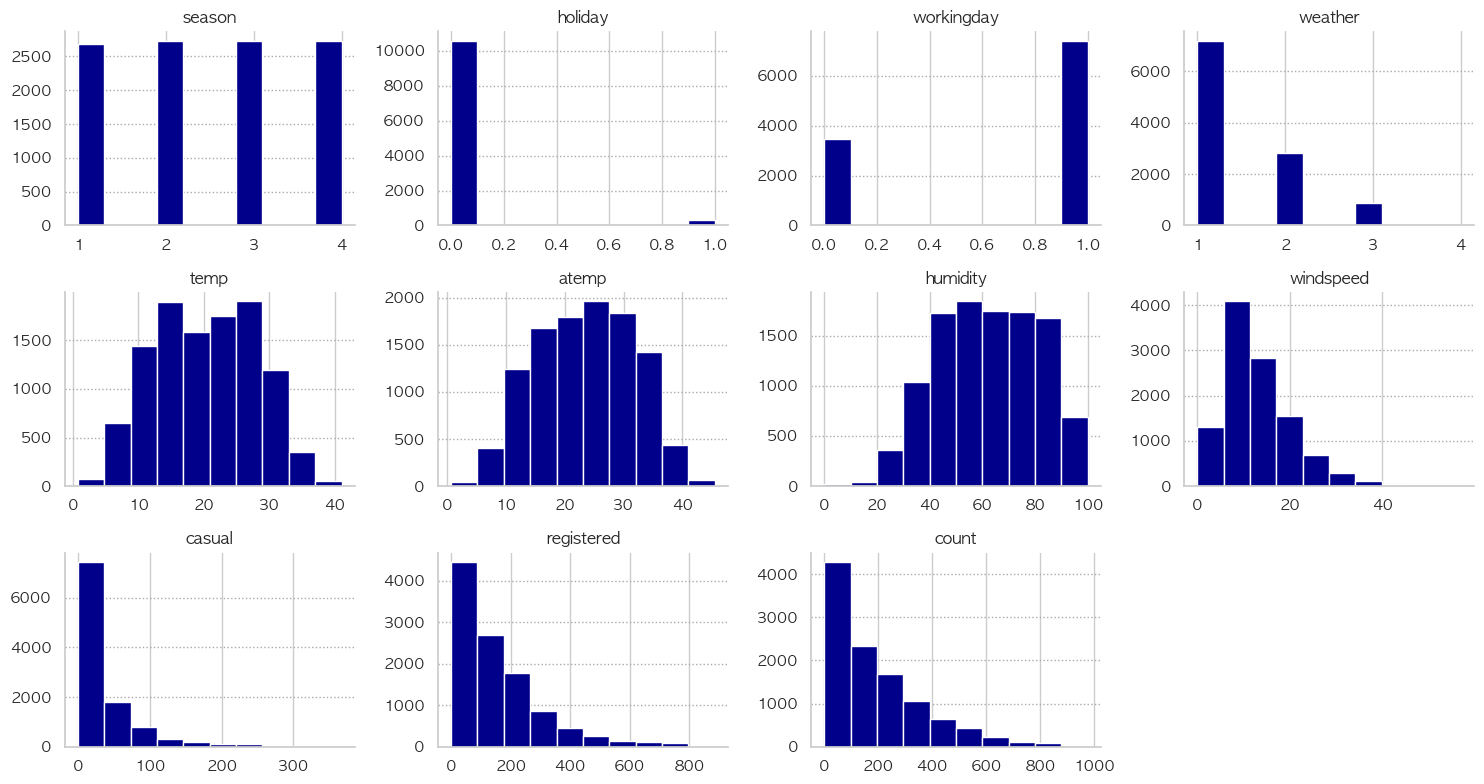

In [202]:
# 히스토그램 시각화
# 변수 선별
numeric_df = train_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.flatten()  

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> #### test 데이터

In [203]:
test_df.shape

(6493, 9)

In [204]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [205]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


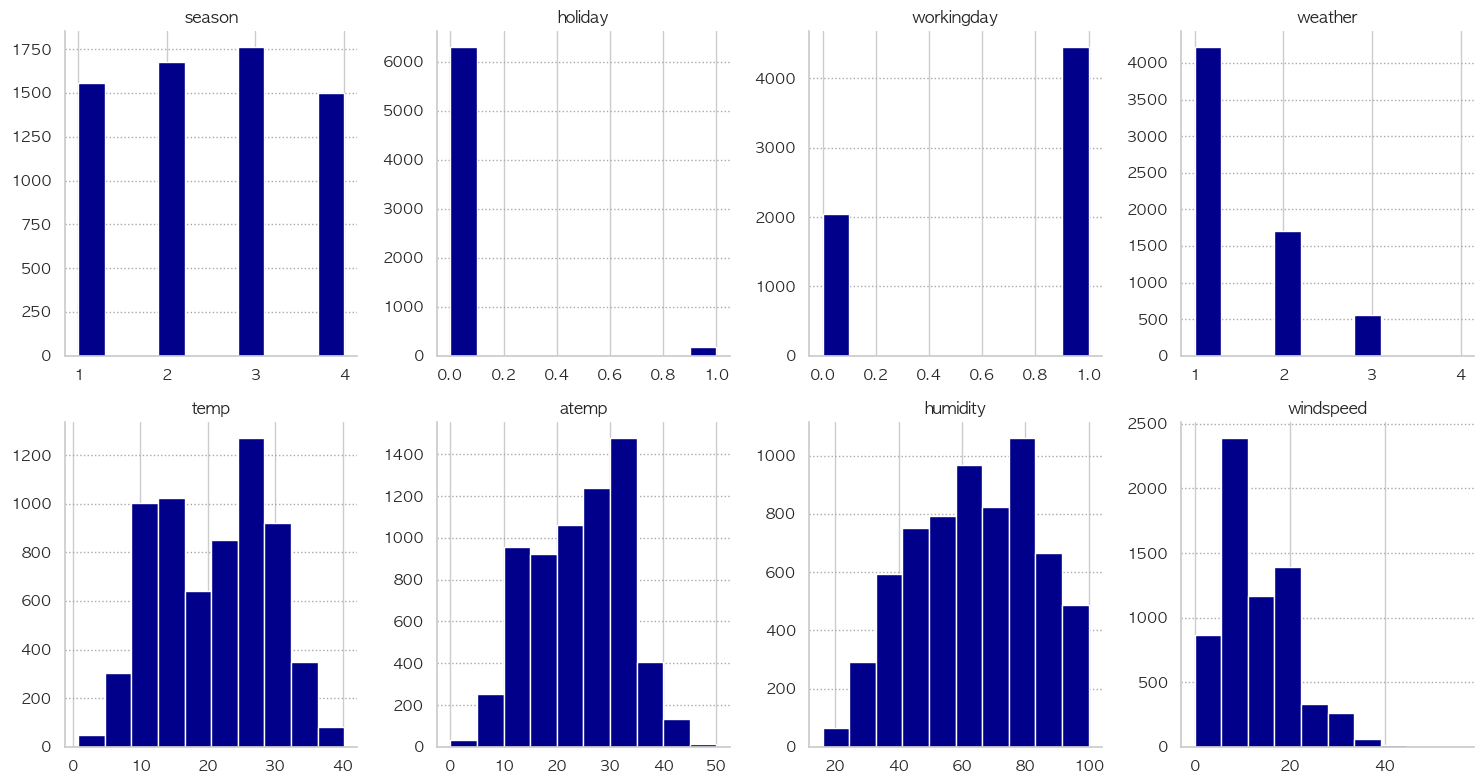

In [206]:
# 히스토그램 시각화
# 변수 선별
numeric_df = test_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()  

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

- train 데이터에는 `casual`, `registered`, `count` 컬럼 존재
- test 데이터에는 `casual`, `registered`, `count` 컬럼 존재하지 않는다.
- 따라서, 모델 훈련시에도 train데이터의 `casual`, `registered` feature는 제외해야한다.

#### 2) 상관관계 확인

- train 데이터 전체 변수간 상관관계 시각화

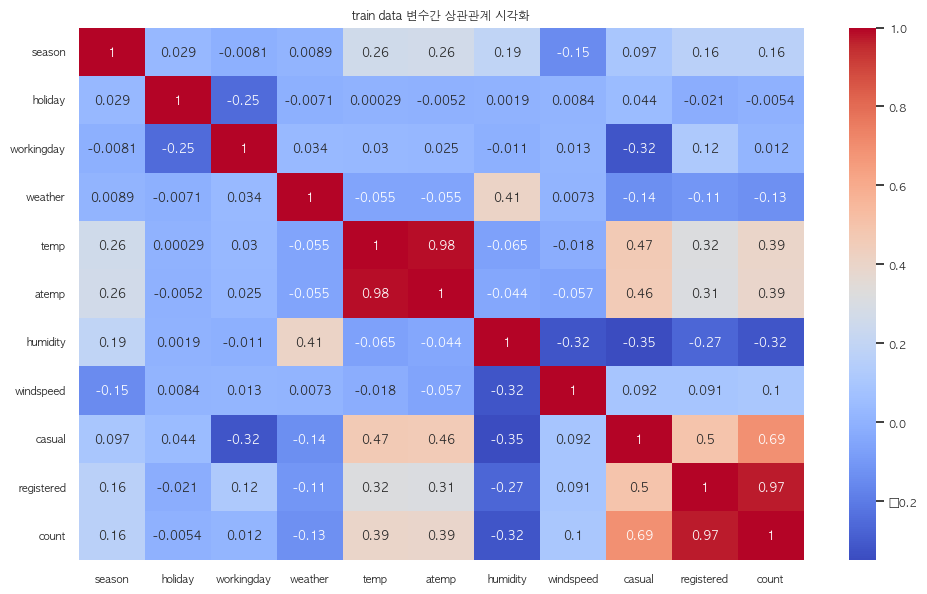

In [207]:
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=train_df.select_dtypes('number').corr(), cbar=True, annot=True, cmap='coolwarm')

plt.title('train data 변수간 상관관계 시각화')
plt.tight_layout()
plt.show()

- 종속변수(`count`)와의 상관관계만 시각화

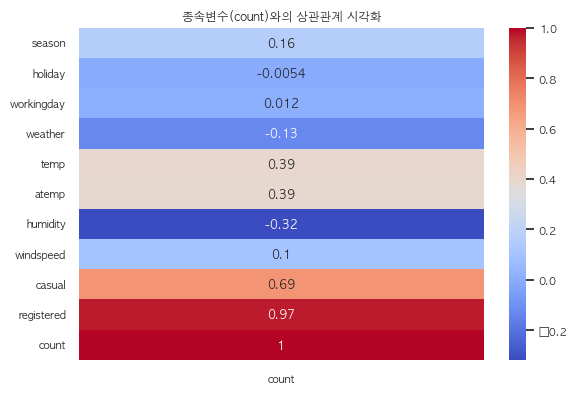

In [208]:
sns.set_theme(rc={'figure.figsize':(6,4)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=train_df.select_dtypes('number').corr()[['count']], cbar=True, annot=True, cmap='coolwarm')

plt.title('종속변수(count)와의 상관관계 시각화')
plt.tight_layout()
plt.show()

> 결과 요약
- count = casual + registered 이므로 당연히 `casual`, `registered` 두 변수와의 상관관계는 높다. 따라서 다중공선성 존재할 것이다.

- 양의 상관관계 : `windspeed`, `temp`, `atemp`, `workingday`, `season`
    - 비교적 큰 상관관계 : `temp`, `atemp`
    -  `temp`, `atemp`는 실측온도와 체감온도로, 두 변수는 거의 동일하므로 다중공선성 존재할 것이다.

- 음의 상관관계 : `holiday`, `weather`, `humidity`
    - 비교적 큰 상관관계 : `humidity`

#### 3) 시계열분석

- 대여수 관련 컬럼 casual, registered, count

In [209]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
eda_df = train_df.copy()

eda_df['year_month'] = eda_df['datetime'].astype('datetime64[ns]').dt.strftime('%Y-%m')
eda_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01


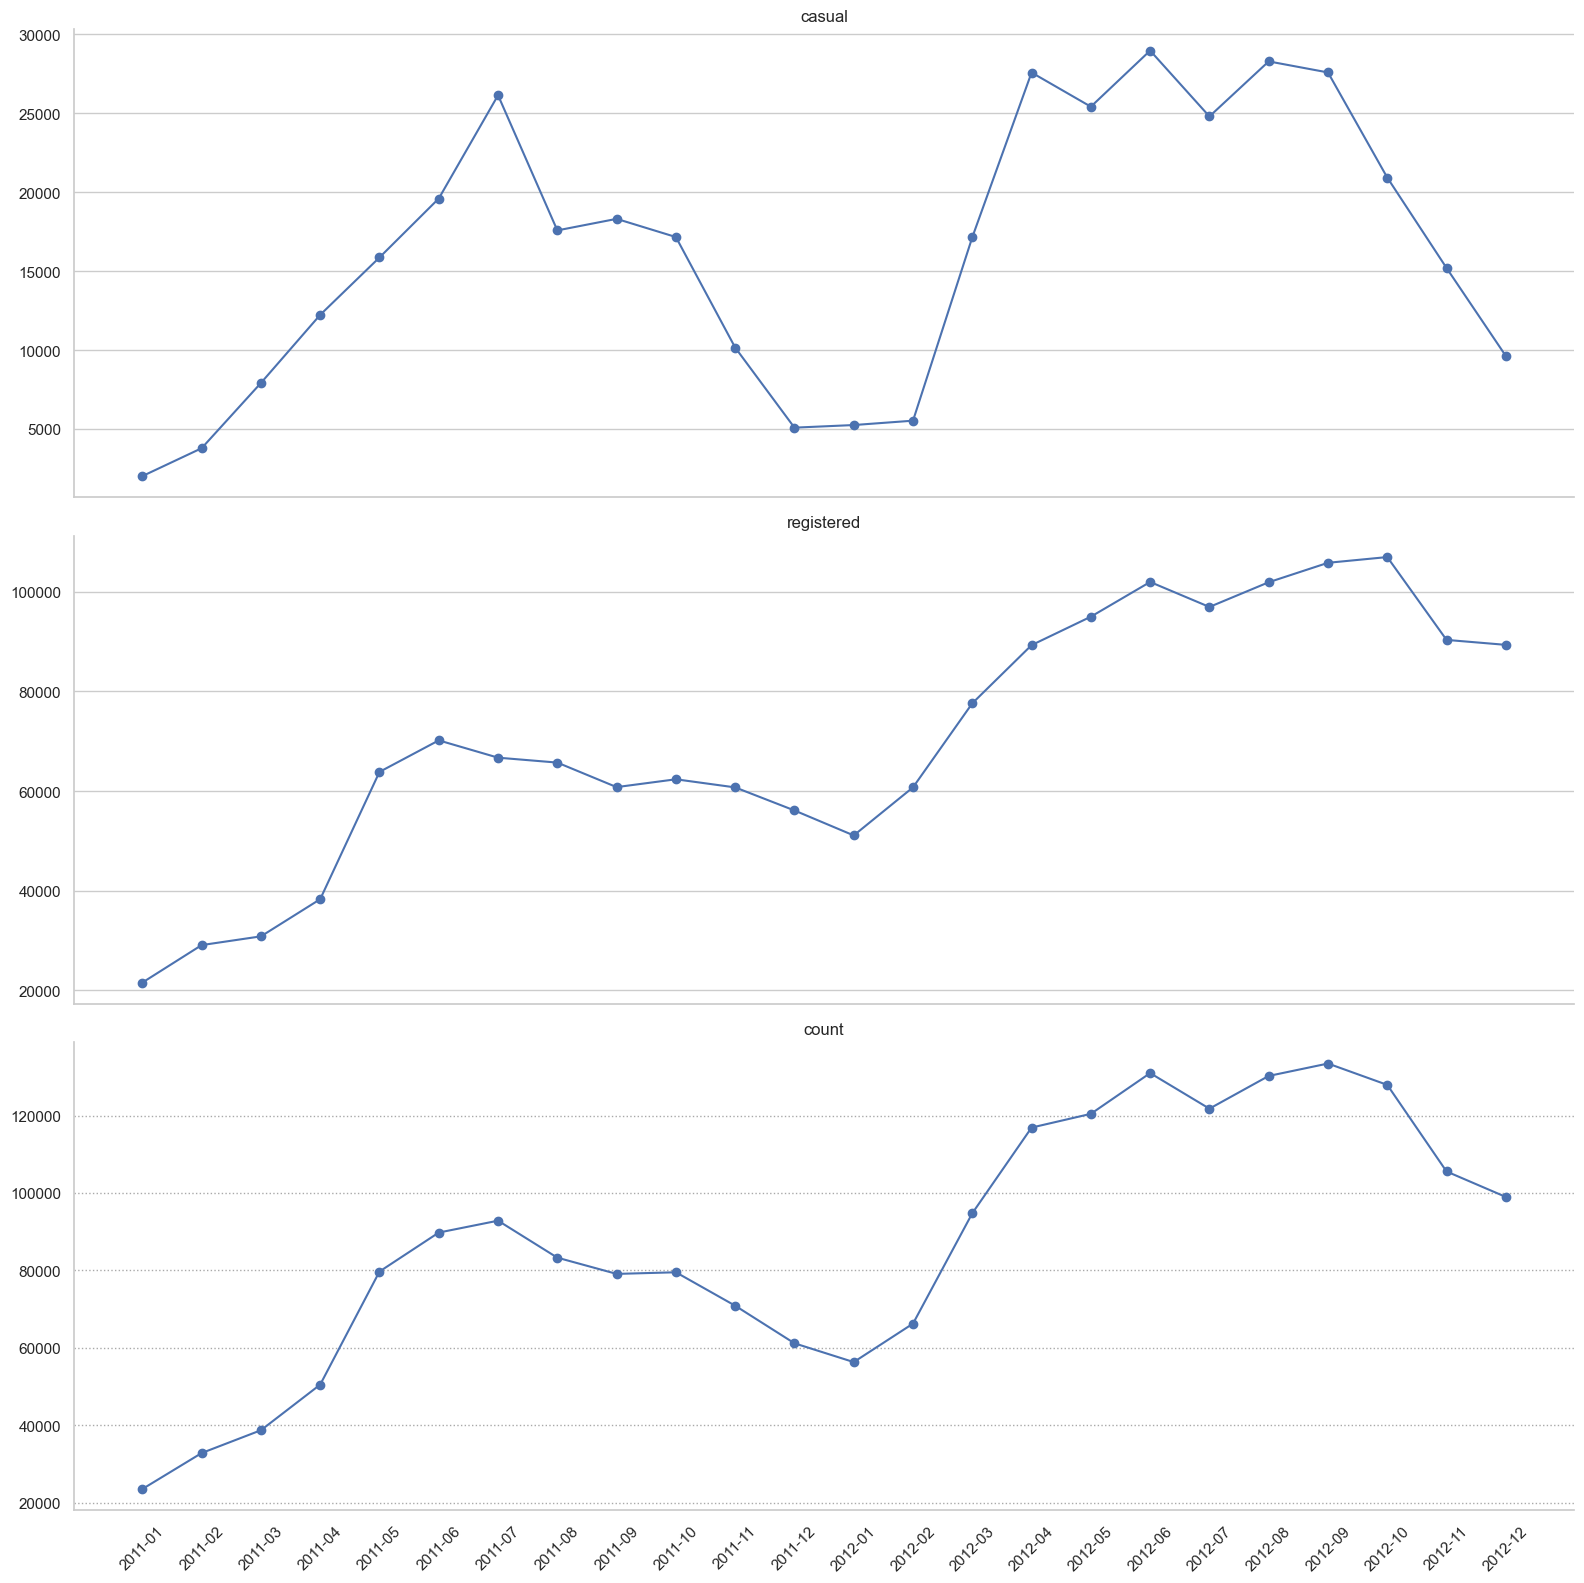

In [211]:
# 서브플롯 생성
fig, axes = plt.subplots(3, 1, figsize=(16, 16))
axes = axes.flatten()
cols = ['casual','registered', 'count']

# sns.set_theme(style='whitegrid')
# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    month_df = eda_df[['year_month', column]].groupby('year_month').sum()[column].reset_index()

    sns.set_theme(style='whitegrid')
    axes[i].plot(month_df.reset_index()['year_month'], month_df.reset_index()[column], marker='o')
    axes[i].set_title(column)
 
    if i == len(cols) - 1:
        axes[i].set_xticks(month_df['year_month'])
        axes[i].set_xticklabels(month_df['year_month'], rotation=45)
        axes[i].grid(False)
        axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    else:
        axes[i].set_xticks([])
        axes[i].grid(axis='x', linestyle=':', color='darkgrey')
 
    #axes[i].set_ylim(bottom=0)
    axes[i].spines[['top','right']].set_visible(False)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 총 대여수, 총 회원 대여수, 총 비회원 대여수 추이가 거의 동일하고, 2~4월에 증가했다가 10월까지 유지되고 이후 감소하는 패턴이 2년간 동일하게 관찰

- temp,atemp, humidity, windspeed

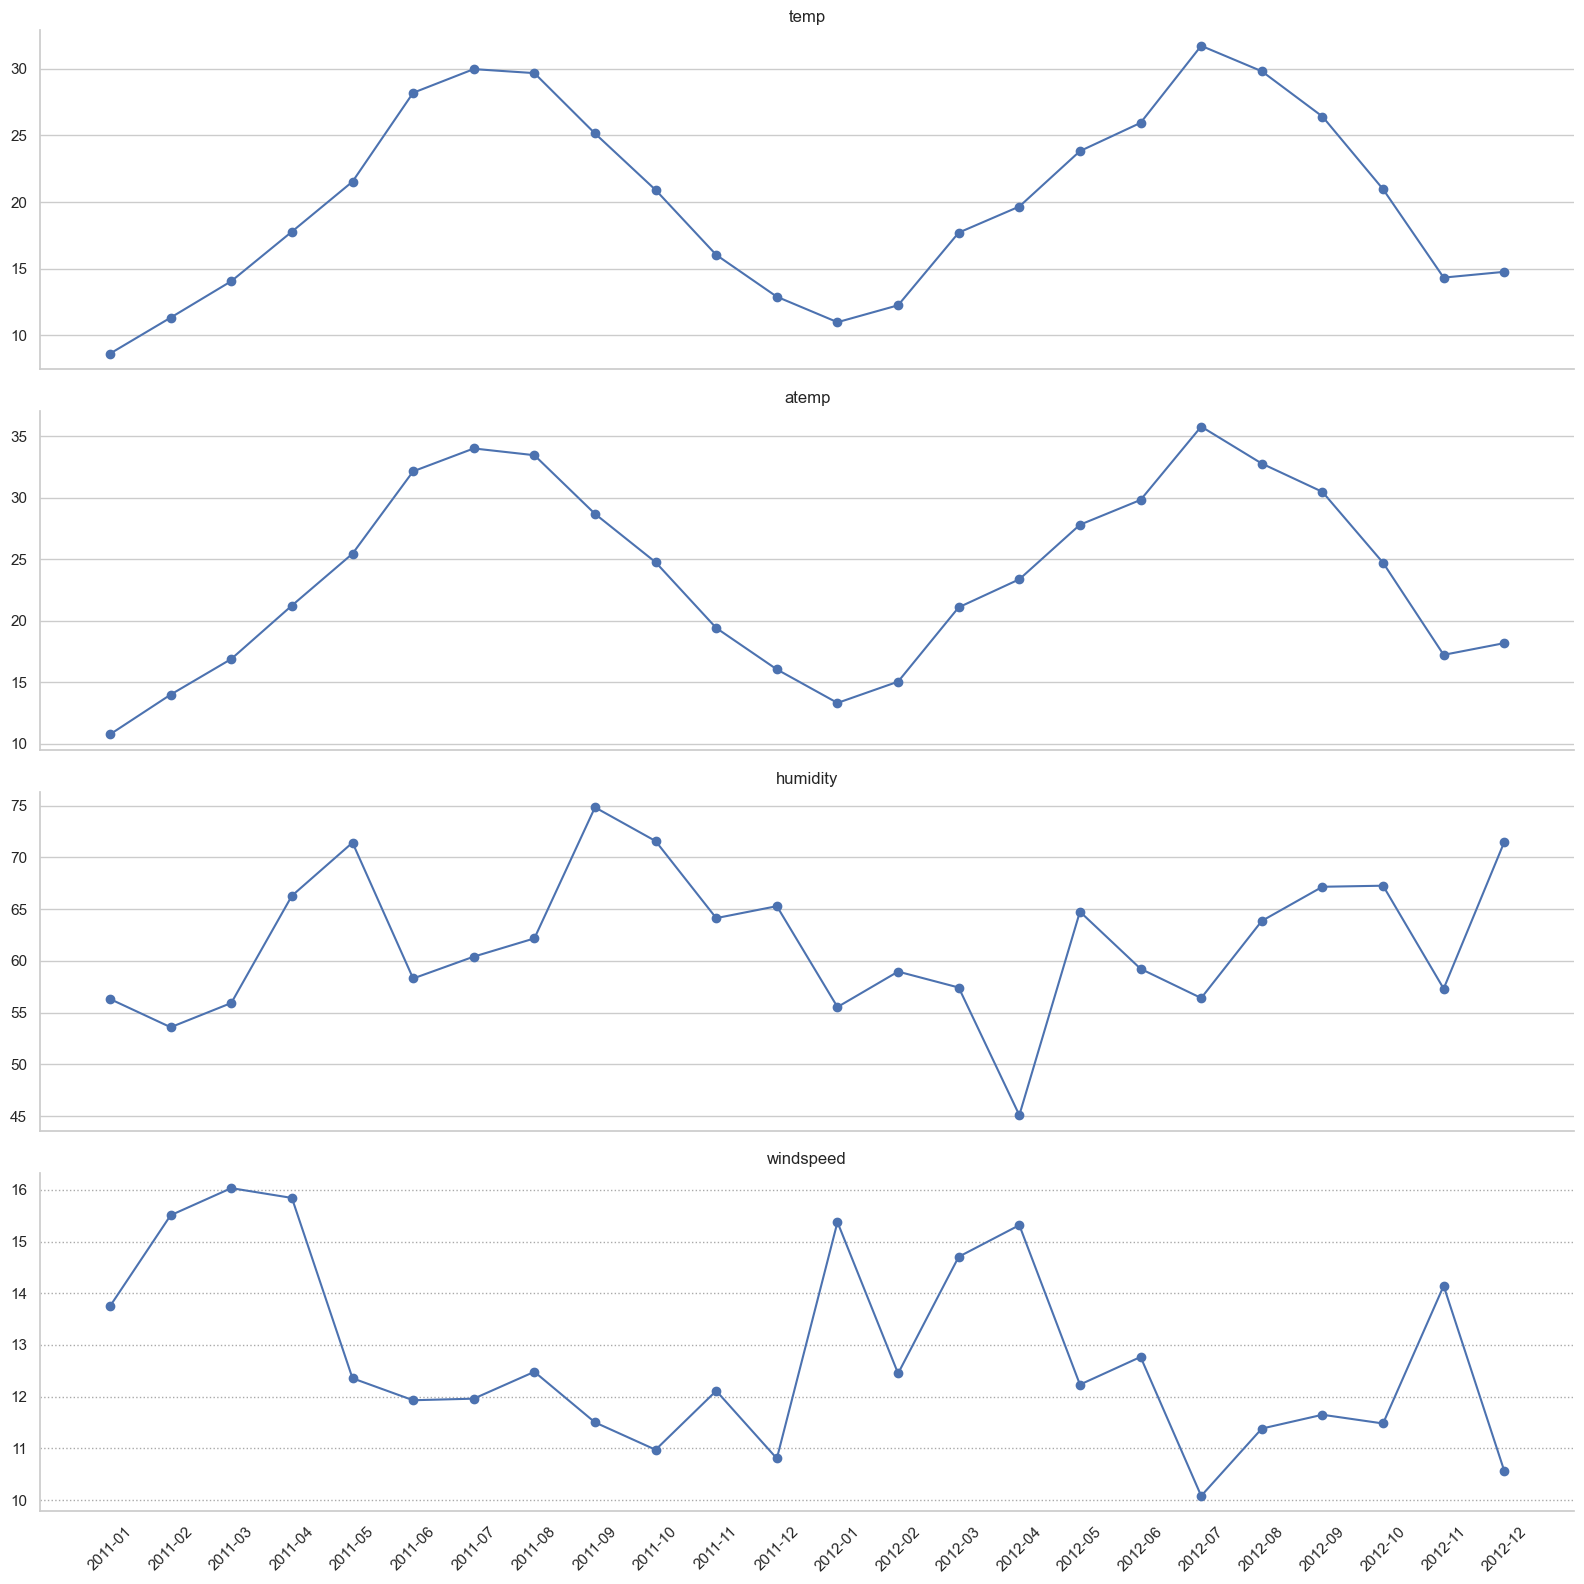

In [212]:
# 서브플롯 생성
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
axes = axes.flatten()
cols = ['temp','atemp', 'humidity', 'windspeed']

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    sns.set_theme(style='whitegrid')
    month_df = eda_df[['year_month', column]].groupby('year_month').mean()[column].reset_index()

    axes[i].plot(month_df.reset_index()['year_month'], month_df.reset_index()[column], marker='o')
    axes[i].set_title(column)
 
    if i == len(cols) - 1:
        axes[i].set_xticks(month_df['year_month'])
        axes[i].set_xticklabels(month_df['year_month'], rotation=45)
        axes[i].grid(False)
        axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    else:
        axes[i].set_xticks([])
        axes[i].grid(axis='x', linestyle=':', color='darkgrey')
 
    #axes[i].set_ylim(bottom=0)
    axes[i].spines[['top','right']].set_visible(False)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
1. 각 변수의 추이와 총 대여수인 count 추이를 비교해보면 앞선 count와의 상관관계 분석 결과를 지지한다는 사실을 알 수 있다.
2. temp, atemp와 비례, humidity와 windspeed 반비례

- 시간별/요일별/월별/연도별 대여수 차이

In [213]:
# 연도 컬럼 만들기
eda_df['year'] = eda_df['datetime'].astype('datetime64[ns]').dt.year
eda_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01,2011


In [214]:
# 월, 시간 컬럼 만들기
eda_df['month'] = eda_df['datetime'].astype('datetime64[ns]').dt.month
eda_df['hour'] = eda_df['datetime'].astype('datetime64[ns]').dt.hour
eda_df['weekday'] = eda_df['datetime'].astype('datetime64[ns]').dt.weekday

eda_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_month,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01,2011,1,2,5


- 연도별 자전거 대여량 시각화

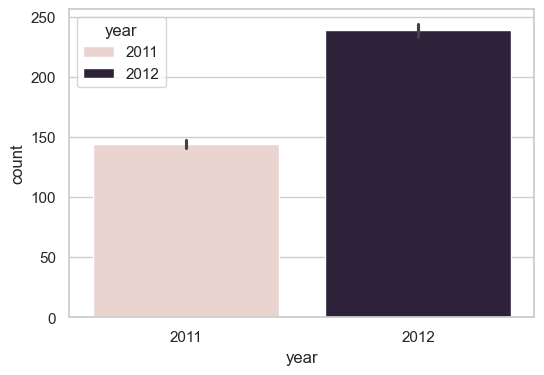

In [215]:
# 연도별 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,4)})
sns.barplot(data=eda_df, x='year', y='count', hue='year')
plt.show()

- 월별 자전거 대여량 시각화

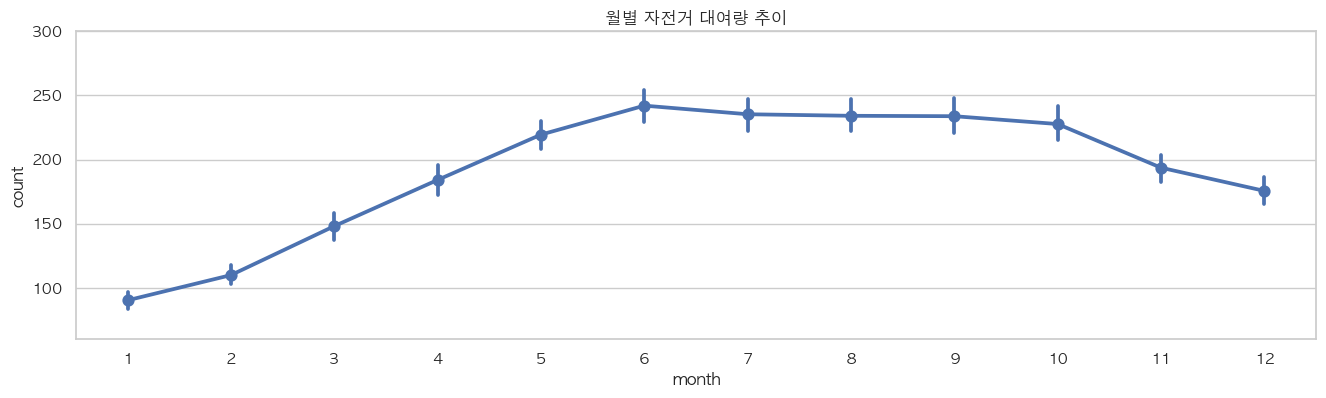

In [216]:
# 월별 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(16,4)},font='AppleGothic')
sns.pointplot(data=eda_df, x='month',y='count')
plt.title('월별 자전거 대여량 추이')
plt.ylim(60,300)
plt.show()

- 요일별 자전거 대여량 시각화

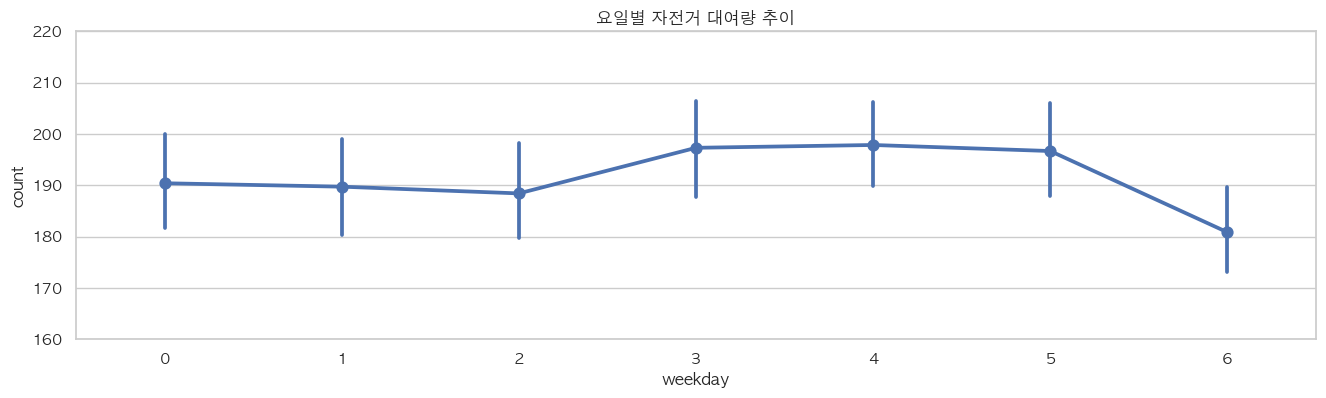

In [217]:
# 요일별 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(16,4)},font='AppleGothic')
sns.pointplot(data=eda_df, x='weekday',y='count')
plt.title('요일별 자전거 대여량 추이')
plt.ylim(160,220)
plt.show()

- 시간대별 자전거 대여량 시각화

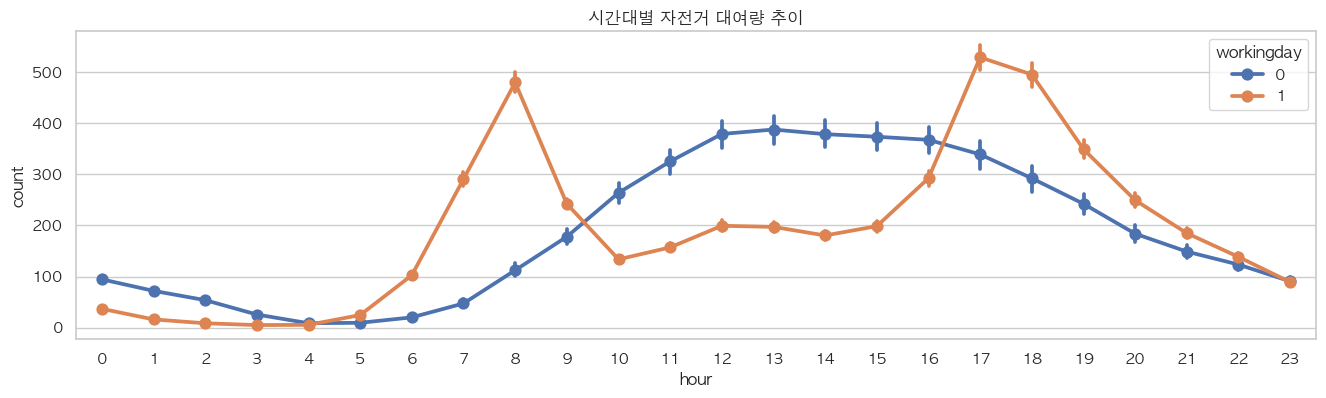

In [218]:
# workingday별 시간대별 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(16,4)},font='AppleGothic')
sns.pointplot(data=eda_df, x='hour',y='count', hue='workingday')
plt.title('시간대별 자전거 대여량 추이')
plt.show()

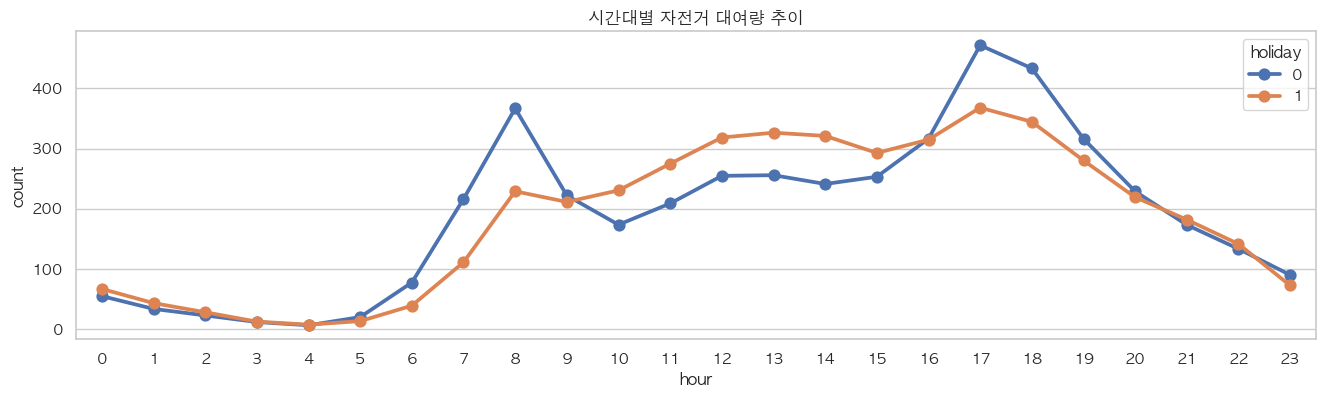

In [219]:
# holiday별 시간대별 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(16,4)},font='AppleGothic')
sns.pointplot(data=eda_df, x='hour',y='count', hue='holiday', ci=None)
plt.title('시간대별 자전거 대여량 추이')
plt.show()

> 결론
1. 2011년보다 2012년에 대여량이 많았다.
    - 서비스 고도화 및 홍보의 영향으로 인한 자연스런 현상으로 유추할 수 있다.

2. 2월부터 대여량이 상승하여 여름, 가을 쯤인 6~10월에 대여량이 강 많다.
    - 계절별 대여량 비교하여 계절이 대여량에 영향을 미칠 수 있다는 사실을 교차 검증헤보기로 한다.

3. workingday, holiday 별 시간대 자전거 대여량 추이를 보니 출,퇴근 시간에 대여량이 급격히 증가하는 추세가 관찰된다.
    - workingday, holiday 및 시간대 모두 대여량에 영향을 미칠 것이라는 사실을 추론할 수 있다.
    - workingday, holiday별 대여량 비교하여 평일/근무일, 주말/공휴일이 대여량에 영향을 미칠 수 있다는 사실을 교차 검증헤보기로 한다.

#### 4) 변수별 분석

- workingday

In [220]:
# workingday별 대여수 비교
tmp_df = eda_df[['workingday','count']].groupby('workingday').sum().reset_index()
tmp_df

,workingday,count
0,0,654872
1,1,1430604


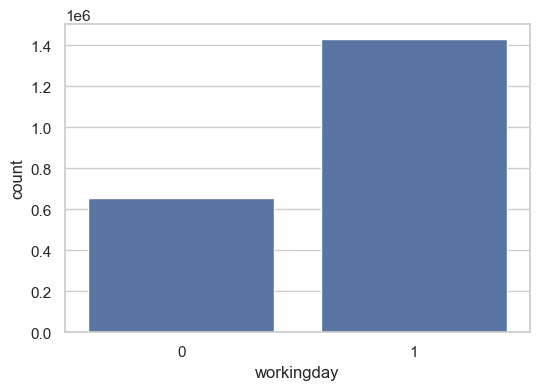

In [221]:
# 주말 및 공휴일(0) / 근무일(1)
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,4)})
sns.barplot(x=tmp_df['workingday'], y=tmp_df['count'])
plt.show()

- holiday

In [222]:
# holiday별 대여수 비교
tmp_df = eda_df[['holiday','count']].groupby('holiday').sum().reset_index()
tmp_df

,holiday,count
0,0,2027668
1,1,57808


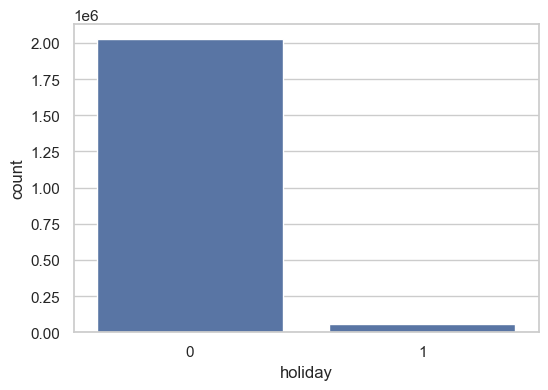

In [223]:
# 평일(0) / 공휴일(1)
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,4)})
sns.barplot(x=tmp_df['holiday'], y=tmp_df['count'])
plt.show()

- season

In [227]:
# holiday별 대여수 비교
tmp_df = eda_df[['season','count']].groupby('season').sum().reset_index()
tmp_df

,season,count
0,1,312498
1,2,588282
2,3,640662
3,4,544034


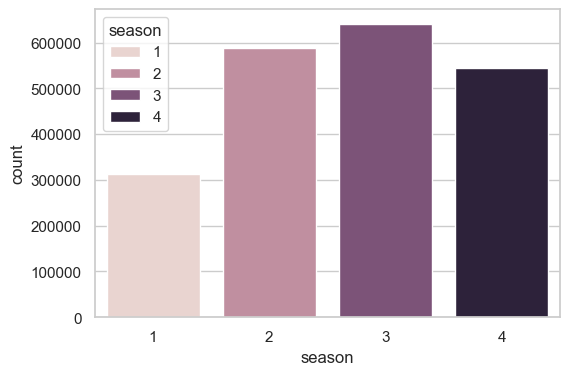

In [228]:
# 1: 봄, 2: 여름, 3: 가을, 4: 겨울
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,4)})
sns.barplot(x=tmp_df['season'], y=tmp_df['count'], hue=tmp_df['season'])
plt.show()

- weather

In [229]:
# weather별 대여수 비교
tmp_df = eda_df[['weather','count']].groupby('weather').sum().reset_index()
tmp_df

,weather,count
0,1,1476063
1,2,507160
2,3,102089
3,4,164


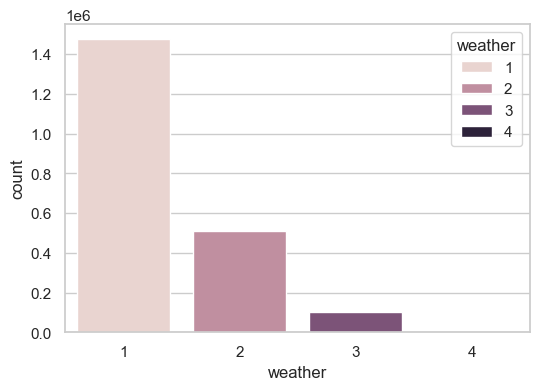

In [230]:
# 1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설
sns.set_theme(style='whitegrid',rc={'figure.figsize':(6,4)})
sns.barplot(x=tmp_df['weather'], y=tmp_df['count'], hue=tmp_df['weather'])
plt.show()

- 체감온도와 실제온도 차이

In [231]:
# 체감온도와 실제온도 차이 컬럼 생성
eda_df['temp_diff'] = abs(eda_df['atemp'] - eda_df['temp'])

eda_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_month,year,month,hour,weekday,temp_diff
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01,2011,1,0,5,4.555
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01,2011,1,1,5,4.615
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01,2011,1,2,5,4.615


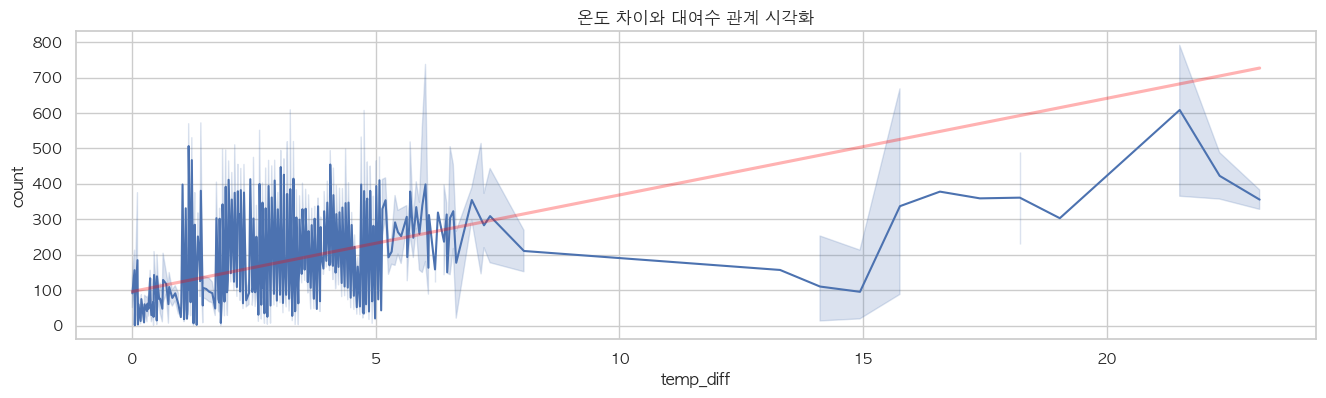

In [232]:
# 온도차이와 대여수 관계 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(16,4)},font='AppleGothic')
sns.lineplot(data=eda_df,x='temp_diff',y='count')
sns.regplot(data=eda_df, x="temp_diff", y="count", scatter=False, ci=None, 
            line_kws={"color": "red", "alpha": 0.3}, label="추세선")

plt.title('온도 차이와 대여수 관계 시각화')
plt.show()

> 결론
1. 평일/근무일이 주말/공휴일보다 대여 자전거 이용량이 많다. $\rightarrow$ 시계열분석 결과 교차검증 완료

2. 비나 눈이 오는 날에는 그렇지 않은 날 비교하여 자전거 이용량이 크게 떨어진다.

3. 맑은 날에 자전거를 가장 많이 대여한다.

4. 가을에 가장 많이 자전거를 대여하고, 봄에 가장 적게 대여한다. $\rightarrow$ 시계열분석 결과 교차검증 완료

5. 체감온도와 실제온도의 차이가 클수록 대여량이 증가하는 경향성 확인 $\rightarrow$ 체감온도와 실제온도 차이도 대여량에 영향을 주는 변수일 수 있다는 추론 가능

## Feature Engineering

### 결측값 처리

In [233]:
# 컬럼별 결측값 확인
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### 중복값 처리

In [234]:
# 중복값 확인
train_df.duplicated().sum()

np.int64(0)

### Feature 생성 및 선별
- datetime 컬럼에서 year, month, hour 생성
- atemp와 temp의 차이의 절댓값인 temp_diff 생성

#### 1. Feature 생성

- 년, 월, 시간대, 요일 컬럼 생성 (year, month, hour, weekday)

In [235]:
# 년, 월, 시간대, 요일 컬럼 만들기
train_df['year'] = train_df['datetime'].astype('datetime64[ns]').dt.year
train_df['month'] = train_df['datetime'].astype('datetime64[ns]').dt.month
train_df['hour'] = train_df['datetime'].astype('datetime64[ns]').dt.hour
train_df['weekday'] = train_df['datetime'].astype('datetime64[ns]').dt.weekday

train_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5


- 체감온도와 실제온도 차이 컬럼 생성(temp_diff)

In [236]:
# 절댓값으로 생성
train_df['temp_diff'] = abs(train_df['atemp'] - train_df['temp'])

train_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday,temp_diff
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5,4.555
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,4.615
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5,4.615


#### 2. Feature 선별
- datetime : 타임스탬프 데이터라 독립변수로 활용되기 어려워, 해당 데이터 컬럼에서 파생할 수 있는 변수를 생성하여 추가 완료하였으므로 삭제

- temp : atemp, temp_diff Feature와 연관성이 높아 삭제해도 된다고 판단

- casual, registered : TEST 데이터 셋에 존재하지 않는 데이터이자, count와 밀접하게 관련되어 있으므로 삭제

In [318]:
# 데이터 누수 방지를 위해 데이터 프레임 복제 후 진행
select_df = train_df.copy()

# 컬럼 삭제
select_df = select_df.drop(columns=['datetime','temp','casual', 'registered'])

select_df.head(3)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
0,1,0,0,1,14.395,81,0.0,16,2011,1,0,5,4.555
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,5,4.615
2,1,0,0,1,13.635,80,0.0,32,2011,1,2,5,4.615


In [319]:
select_df.shape

(10886, 13)

### 이상치 처리

- 실제 온도와 체감온도 간 상관관계가 높으나, 실제 온도보다 체감 온도가 대여 수에 더 크게 영향을 미칠 것이므로 실제 온도 Feature는 제외한다.

In [301]:
# 수치형 변수 선택
numeric_cols = list(select_df.select_dtypes('number').columns)

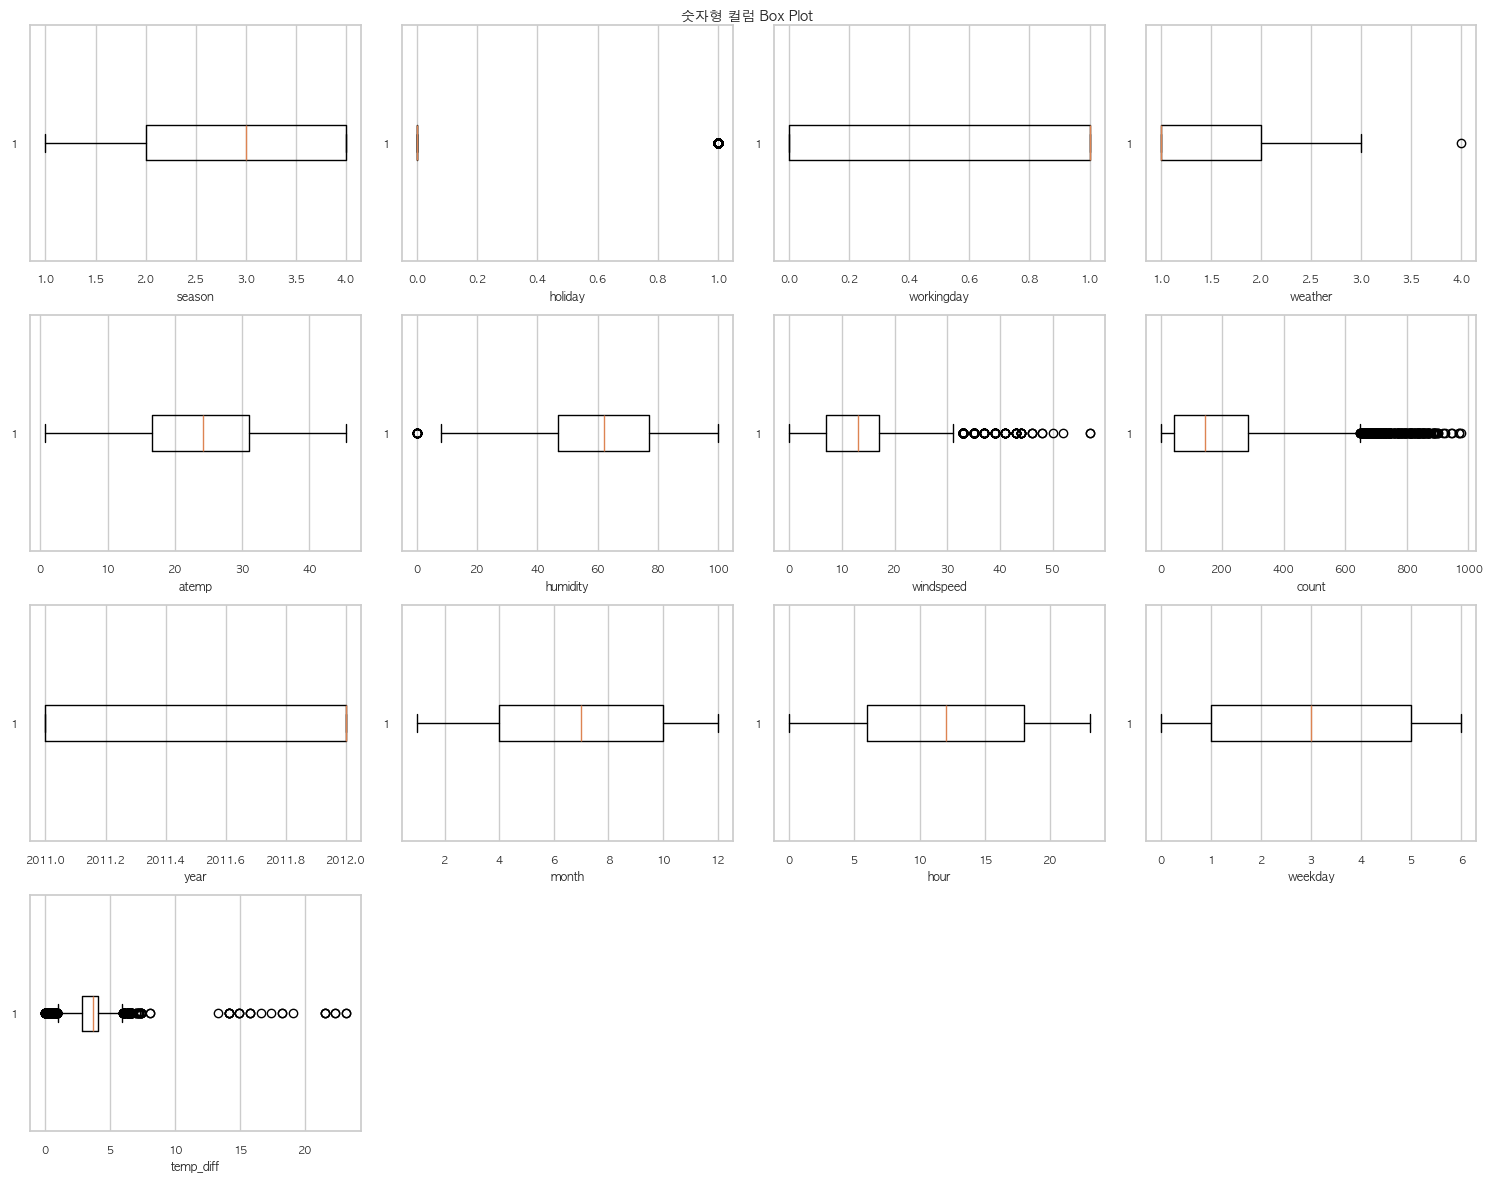

In [302]:
# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)

fig, axes = plt.subplots(4,4,figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(select_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('숫자형 컬럼 Box Plot')

fig.tight_layout()
fig.show()

> 결과 요약
- `season`, `workingday`, `hoilday`, `hoilday`, `year`, `month`, `hour`는 범주형 변수이므로 이상치를 처리하지 않는다.
- 기술통계값 확인하여 이상치 처리 판단

In [320]:
select_df.describe()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,11.541613,3.013963,3.509199
std,1.116174,0.166599,0.466159,0.633839,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,6.915838,2.004585,1.365671
min,1.000000,0.000000,0.000000,1.000000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,0.010000
25%,2.000000,0.000000,0.000000,1.000000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,6.000000,1.000000,2.790000
50%,3.000000,0.000000,1.000000,1.000000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,12.000000,3.000000,3.680000
75%,4.000000,0.000000,1.000000,2.000000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,18.000000,5.000000,4.055000
max,4.000000,1.000000,1.000000,4.000000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,23.000000,6.000000,23.140000


- 박스플롯상 이상치가 많아보이는 컬럼의 이상치 개수 확인

In [321]:
# temp_diff 컬럼 이상치 개수 확인
q1 = select_df['temp_diff'].quantile(0.25)
q3 = select_df['temp_diff'].quantile(0.75)
iqr = q3-q1

print(f"전체 이상치 개수: {len(select_df[(select_df['temp_diff'] < (q1 - (1.5*iqr)))|(select_df['temp_diff'] > (q3 + (1.5*iqr)))])}")
print(f"Upper 이상치 개수: {len(select_df[select_df['temp_diff'] > (q3 + (1.5*iqr))])}")
print(f"Lower 이상치 개수: {len(select_df[select_df['temp_diff'] < (q1 - (1.5*iqr))])}")

전체 이상치 개수: 619
Upper 이상치 개수: 241
Lower 이상치 개수: 378


In [322]:
# windspeed 컬럼 이상치 개수 확인
q1 = select_df['windspeed'].quantile(0.25)
q3 = select_df['windspeed'].quantile(0.75)
iqr = q3-q1

print(f"전체 이상치 개수: {len(select_df[(select_df['windspeed'] < (q1 - (1.5*iqr)))|(select_df['windspeed'] > (q3 + (1.5*iqr)))])}")
print(f"Upper 이상치 개수: {len(select_df[select_df['windspeed'] > (q3 + (1.5*iqr))])}")
print(f"Lower 이상치 개수: {len(select_df[select_df['windspeed'] < (q1 - (1.5*iqr))])}")

전체 이상치 개수: 227
Upper 이상치 개수: 227
Lower 이상치 개수: 0


> - temp_diff 컬럼의 이상치는 데이터의 개수가 상대적으로 많고 데이터의 보존을 위해 중앙값으로 변경하는 방식으로 이상치를 처리한다.
> - windspeed 컬럼의 이상치는 모두 Upper 이상치이며 데이터의 보존을 위해 최대값으로 변경하는 방식으로 이상치를 처리한다.

- 이상치 처리 진행

In [323]:
# temp_diff 중앙값
select_df['temp_diff'].quantile(0.50)

np.float64(3.6799999999999997)

In [324]:
# temp_diff 사분위수 도출
q1 = select_df['temp_diff'].quantile(0.25)
q3 = select_df['temp_diff'].quantile(0.75)
iqr = q3-q1

mask = (select_df['temp_diff'] < (q1 - (1.5*iqr)))|(select_df['temp_diff'] > (q3 + (1.5*iqr)))

select_df.loc[mask, 'temp_diff'] = select_df['temp_diff'].quantile(0.50)

In [325]:
# windspeed 사분위수 도출
q1 = select_df['windspeed'].quantile(0.25)
q3 = select_df['windspeed'].quantile(0.75)
iqr = q3-q1

# windspeed 이상치 범주 내 최댓값으로
mask = (select_df['windspeed'] < (q1 - (1.5*iqr)))|(select_df['windspeed'] > (q3 + (1.5*iqr)))

select_df.loc[mask, 'windspeed'] = q3 + (1.5*iqr)

In [326]:
# 이상치 처리 후 기술통계량 확인
select_df.describe()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,23.655084,61.886460,12.703540,191.574132,2011.501929,6.521495,11.541613,3.013963,3.533130
std,1.116174,0.166599,0.466159,0.633839,8.474601,19.245033,7.882794,181.144454,0.500019,3.444373,6.915838,2.004585,0.956184
min,1.000000,0.000000,0.000000,1.000000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,0.955000
25%,2.000000,0.000000,0.000000,1.000000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,6.000000,1.000000,2.995000
50%,3.000000,0.000000,1.000000,1.000000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,12.000000,3.000000,3.680000
75%,4.000000,0.000000,1.000000,2.000000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,18.000000,5.000000,4.007500
max,4.000000,1.000000,1.000000,4.000000,45.455000,100.000000,31.992500,977.000000,2012.000000,12.000000,23.000000,6.000000,5.900000


In [ ]:
# 이상치 처리 후 데이터 개수 유지
select_df.shape

(10886, 13)

### 표준화
- 독립변수 중 수치형 변수간 스케일 차이가 크게 나므로 표준화를 실시한다.
- `다항회귀를 위한 표준화는 다항회귀를 진행할 때 다항회귀 데이터로 변환한 후 표준화를 따로 진행`하기로 한다.
- Test 데이터에는 casual, regitstered 컬럼이 존재하지 않으므로, Training 데이터에서도 제외하고 모델을 학습시킨다.

In [328]:
# 표준화를 위한 데이터 프레임 복제
standardaized_df = select_df.copy()

# 표준화 모델 생성
scaler = StandardScaler()
cols = ['atemp','humidity','windspeed','temp_diff']

# 표준화 모델 적용
standardaized_df[cols] = scaler.fit_transform(standardaized_df[cols])
standardaized_df.head(3)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
0,1,0,0,1,-1.092737,0.993213,-1.611627,16,2011,1,0,5,1.068745
1,1,0,0,1,-1.182421,0.941249,-1.611627,40,2011,1,1,5,1.131498
2,1,0,0,1,-1.182421,0.941249,-1.611627,32,2011,1,2,5,1.131498


In [329]:
# 표준화 확인
standardaized_df.describe()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
count,10886.000000,10886.000000,10886.000000,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,1.088600e+04
mean,2.506614,0.028569,0.680875,1.418427,-2.193114e-16,1.148774e-16,-5.743869e-17,191.574132,2011.501929,6.521495,11.541613,3.013963,-3.916274e-16
std,1.116174,0.166599,0.466159,0.633839,1.000046e+00,1.000046e+00,1.000046e+00,181.144454,0.500019,3.444373,6.915838,2.004585,1.000046e+00
min,1.000000,0.000000,0.000000,1.000000,-2.701736e+00,-3.215858e+00,-1.611627e+00,1.000000,2011.000000,1.000000,0.000000,0.000000,-2.696393e+00
25%,2.000000,0.000000,0.000000,1.000000,-8.248654e-01,-7.735577e-01,-7.233860e-01,42.000000,2011.000000,4.000000,6.000000,1.000000,-5.628146e-01
50%,3.000000,0.000000,1.000000,1.000000,6.902305e-02,5.899992e-03,3.735645e-02,145.000000,2012.000000,7.000000,12.000000,3.000000,1.536075e-01
75%,4.000000,0.000000,1.000000,2.000000,8.738177e-01,7.853577e-01,5.448014e-01,284.000000,2012.000000,10.000000,18.000000,5.000000,4.961305e-01
max,4.000000,1.000000,1.000000,4.000000,2.572501e+00,1.980526e+00,2.447082e+00,977.000000,2012.000000,12.000000,23.000000,6.000000,2.475443e+00


---

## 예측 모델 개발

### 1. 다중 선형 회귀

#### 추가 Feature Engineering

- 독립변수(X) / 종속변수(y) 분할
    - Test 데이터 셋에 대여 관련 컬럼들(casual, registered, count)이 없기 때문에 모델 학습시에도 제외해준다.

In [330]:
# 변수 나눔
X = standardaized_df.drop(['count'], axis=1)
y = standardaized_df[['count']]

In [331]:
X

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,weekday,temp_diff
0,1,0,0,1,-1.092737,0.993213,-1.611627,2011,1,0,5,1.068745
1,1,0,0,1,-1.182421,0.941249,-1.611627,2011,1,1,5,1.131498
2,1,0,0,1,-1.182421,0.941249,-1.611627,2011,1,2,5,1.131498
3,1,0,0,1,-1.092737,0.681430,-1.611627,2011,1,3,5,1.068745
4,1,0,0,1,-1.092737,0.681430,-1.611627,2011,1,4,5,1.068745
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,-0.467310,-0.617666,1.687190,2012,12,19,2,0.608562
10882,4,0,1,1,-0.735182,-0.253919,0.291504,2012,12,20,2,-0.907952
10883,4,0,1,1,-0.913959,-0.046064,0.291504,2012,12,21,2,-1.634833
10884,4,0,1,1,-0.735182,-0.046064,-0.850035,2012,12,22,2,-0.050337


In [332]:
X.shape

(10886, 12)

In [333]:
y.shape

(10886, 1)

- 범주형 변수 one-hot encoding

In [334]:
# One-hot Encoding 적용할 컬럼 리스트 생성
cols_encoding = ['season', 'holiday','workingday','weather','year','month','hour','weekday']

# One-hot Encoding을 특정 열에만 적용
X = pd.get_dummies(X, columns=cols_encoding, drop_first=True, dtype=int) # 다중공선성 문제를 피하기 위해 첫번째 열을 삭제

# 결과 확인
X.head()

,atemp,humidity,windspeed,temp_diff,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,...,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,-1.092737,0.993213,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-1.182421,0.941249,-1.611627,1.131498,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.182421,0.941249,-1.611627,1.131498,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-1.092737,0.681430,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-1.092737,0.681430,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### 다중 선형 회귀 모델 개발

In [335]:
# training set, test set 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# 각 데이터 프레임의 모양 확인
print(f'X_train : {X_train.shape}')  
print(f'X_test : {X_test.shape}')   
print(f'y_train : {y_train.shape}')  
print(f'y_test : {y_test.shape}')

X_train : (8708, 53)
X_test : (2178, 53)
y_train : (8708, 1)
y_test : (2178, 1)


In [336]:
# 모델 학습 및 적용
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [337]:
# 학습된 θ 값 확인
print(model.coef_)      
print(model.intercept_)

[[ 3.03647416e+01 -1.67733325e+01 -2.77871548e+00  2.46493006e+00
   4.50225438e+12 -1.09076678e+14  5.39848596e+13 -8.49127953e+13
  -8.49127953e+13 -9.21179945e+00 -6.46322861e+01 -1.63516096e+02
   8.80576869e+01  1.35860252e+01  3.11129375e+01 -4.50225438e+12
  -4.50225438e+12 -4.50225438e+12  1.09076678e+14  1.09076678e+14
   1.09076678e+14 -5.39848596e+13 -5.39848596e+13 -5.39848596e+13
  -1.74334057e+01 -2.83941955e+01 -4.38549419e+01 -4.42589392e+01
  -2.46068940e+01  3.50708231e+01  1.65702268e+02  3.18556369e+02
   1.65238083e+02  1.11503906e+02  1.38003906e+02  1.80656250e+02
   1.71906250e+02  1.54281250e+02  1.68500000e+02  2.27226562e+02
   3.89164062e+02  3.53398438e+02  2.42457031e+02  1.57887695e+02
   1.10542969e+02  7.16679688e+01  3.26054688e+01  1.06640625e+00
   8.75000000e-01  2.79687500e+00  9.50000000e+00 -8.49127953e+13
  -8.49127953e+13]]
[8.49127953e+13]


In [338]:
# 학습 모델로 예측 성능 평가
y_test_prediction = model.predict(X_test)

# 평균 제곱근 오차(RMSE) 계산
mse = mean_squared_error(y_test, y_test_prediction)
rmse = mse ** 0.5
print(f"평균 제곱근 오차: {rmse:.2f}")

평균 제곱근 오차: 102.03


In [339]:
def rmsle(y_true, y_pred, convertExp=True):

    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))) # np.power(a, b) : a^b

# y는 log1p 변환값 (log1p : log(1+x))

rmsle_lr = rmsle(y_test, y_test_prediction, convertExp=False)
print("RMSLE:", rmsle_lr)

RMSLE: 0.8142615573149593


> 결과
- RMSLE: 0.81

### 2. 다중 선형 회귀(Lasso, Lidge)

#### 추가 Feature Engineering

In [340]:
select_df.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
0,1,0,0,1,14.395,81,0.0,16,2011,1,0,5,4.555
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,5,4.615
2,1,0,0,1,13.635,80,0.0,32,2011,1,2,5,4.615
3,1,0,0,1,14.395,75,0.0,13,2011,1,3,5,4.555
4,1,0,0,1,14.395,75,0.0,1,2011,1,4,5,4.555


In [341]:
# 데이터 프레임 복사
feature_engineered_df = select_df.copy()
feature_engineered_df.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
0,1,0,0,1,14.395,81,0.0,16,2011,1,0,5,4.555
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,5,4.615
2,1,0,0,1,13.635,80,0.0,32,2011,1,2,5,4.615
3,1,0,0,1,14.395,75,0.0,13,2011,1,3,5,4.555
4,1,0,0,1,14.395,75,0.0,1,2011,1,4,5,4.555


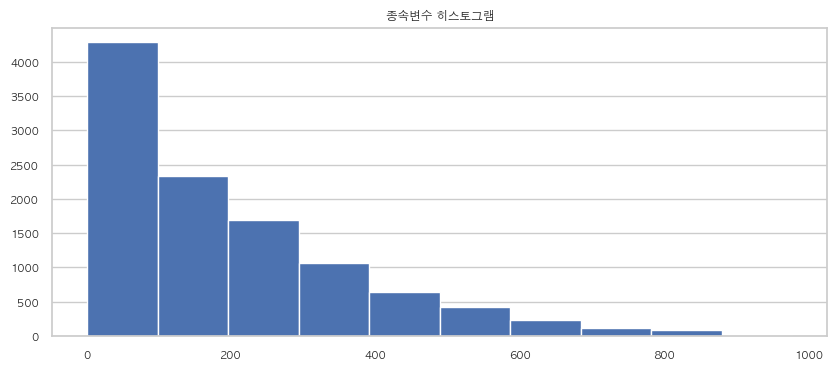

In [342]:
# 종속변수 히스토그램 그려보기
plt.figure(figsize=(10,4))
plt.hist(feature_engineered_df[['count']])
plt.title('종속변수 히스토그램')

plt.grid(axis='x')
plt.show()

- 독립/종속 변수 분할
    - y 값은 로그변환(종속변수 왜도가 0보다 크므로 값들이 왼쪽으로 편향되어 있기 때문에 편향을 완화시켜주기 위해)

In [343]:
# 변수 나눔 - 체감온도 Feature가 존재하므로 temp Feature 제거
X = feature_engineered_df.drop(['count'], axis=1)
y = np.log1p(feature_engineered_df[['count']]).values.ravel()

print(f'독립변수 크기: {X.shape}')
print(f'종속변수 크기: {y.shape}')

독립변수 크기: (10886, 12)
종속변수 크기: (10886,)


- 표준화

In [344]:
X.head(3)

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,weekday,temp_diff
0,1,0,0,1,14.395,81,0.0,2011,1,0,5,4.555
1,1,0,0,1,13.635,80,0.0,2011,1,1,5,4.615
2,1,0,0,1,13.635,80,0.0,2011,1,2,5,4.615


In [345]:
# 표준화 생성 및 적용
scaler = StandardScaler()
X[['atemp','humidity','windspeed','temp_diff']] = scaler.fit_transform(X[['atemp','humidity','windspeed','temp_diff']])

In [346]:
X.describe()

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,weekday,temp_diff
count,10886.000000,10886.000000,10886.000000,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04,10886.000000,10886.000000,10886.000000,10886.000000,1.088600e+04
mean,2.506614,0.028569,0.680875,1.418427,-2.193114e-16,1.148774e-16,-5.743869e-17,2011.501929,6.521495,11.541613,3.013963,-3.916274e-16
std,1.116174,0.166599,0.466159,0.633839,1.000046e+00,1.000046e+00,1.000046e+00,0.500019,3.444373,6.915838,2.004585,1.000046e+00
min,1.000000,0.000000,0.000000,1.000000,-2.701736e+00,-3.215858e+00,-1.611627e+00,2011.000000,1.000000,0.000000,0.000000,-2.696393e+00
25%,2.000000,0.000000,0.000000,1.000000,-8.248654e-01,-7.735577e-01,-7.233860e-01,2011.000000,4.000000,6.000000,1.000000,-5.628146e-01
50%,3.000000,0.000000,1.000000,1.000000,6.902305e-02,5.899992e-03,3.735645e-02,2012.000000,7.000000,12.000000,3.000000,1.536075e-01
75%,4.000000,0.000000,1.000000,2.000000,8.738177e-01,7.853577e-01,5.448014e-01,2012.000000,10.000000,18.000000,5.000000,4.961305e-01
max,4.000000,1.000000,1.000000,4.000000,2.572501e+00,1.980526e+00,2.447082e+00,2012.000000,12.000000,23.000000,6.000000,2.475443e+00


- one-hot encoding

In [347]:
# One-hot Encoding 적용할 컬럼 리스트 생성
cols_encoding = ['season', 'holiday','workingday','weather','year','month','hour','weekday']

# One-hot Encoding을 특정 열에만 적용
X = pd.get_dummies(X, columns=cols_encoding, drop_first=True, dtype=int) # 다중공선성 문제를 피하기 위해 첫번째 열을 삭제

# 결과 확인
X.head()

,atemp,humidity,windspeed,temp_diff,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,...,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,-1.092737,0.993213,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-1.182421,0.941249,-1.611627,1.131498,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.182421,0.941249,-1.611627,1.131498,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-1.092737,0.681430,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-1.092737,0.681430,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### ㄴ 정규화(Lasso) 모델 적용 - L1

In [353]:
## 그리드 서치 활용한 정규화(Lasso) 모델 개발
#train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# 모델 생성
model = Lasso()

#파라미터 그리드
param_grid = {
    'alpha': [0.1, 1, 10, 100,1000],
    'max_iter': [100, 500, 1000, 1500, 2000]
}

#GridSearchCV 설정
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, refit=True, n_jobs=-1)

#그리드 서치 실행 (학습 데이터에 대해서만 학습)
grid_search.fit(X_train, y_train)

#트레이닝 데이터에 대한 예측
y_train_pred = grid_search.predict(X_train)
y_train_pred[y_train_pred < 0] = y_test.min()  # 음수 예측값 보정

#테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)
y_test_pred[y_test_pred < 0] = y_test.min()  # 음수 예측값 보정

In [354]:
# GridSearchCV가 이미 수행된 후 (grid_search.fit(...) 후)
results_df = pd.DataFrame(grid_search.cv_results_)

# rank_test_score 기준으로 정렬 (1이 최고)
results_df = results_df.sort_values(by='rank_test_score')

# 출력할 컬럼 선택 (필요에 따라 추가 가능)
leaderboard = results_df[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']]

# 시도한 parameter 값 중 성능 순 TOP3 출력
leaderboard.iloc[:3,:]

,rank_test_score,mean_test_score,std_test_score,params
0,1,0.226571,0.02016,"{'alpha': 0.1, 'max_iter': 100}"
1,1,0.226571,0.02016,"{'alpha': 0.1, 'max_iter': 500}"
2,1,0.226571,0.02016,"{'alpha': 0.1, 'max_iter': 1000}"


In [359]:
# RMSLE 확인
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))) # np.power(a, b) : a^b

# y는 log1p 변환값 (log1p : log(1+x))
# RMSLE 계산
train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred), convertExp=False)
test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

# 결과 출력
print(f"훈련 데이터 RMSLE: {train_rmsle:.4f}")
print(f"테스트 데이터 RMSLE: {test_rmsle:.4f}")

훈련 데이터 RMSLE: 1.2466
테스트 데이터 RMSLE: 1.2463


> **최종 결과**

In [360]:
print("최적 파라미터:", grid_search.best_params_)
print(f"RMSLE: {test_rmsle:.4f}")

최적 파라미터: {'alpha': 0.1, 'max_iter': 100}
RMSLE: 1.2463


#### ㄴ 정규화(Lidge) 모델 적용 - L2

In [357]:
# Lasso 모델에 사용한 독립변수 종속변수 테이블 그대로 사용
X.head(3)

,atemp,humidity,windspeed,temp_diff,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,...,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,-1.092737,0.993213,-1.611627,1.068745,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-1.182421,0.941249,-1.611627,1.131498,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.182421,0.941249,-1.611627,1.131498,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [358]:
# 로그변환된 테이블
y

array([2.83321334, 3.71357207, 3.49650756, ..., 5.12989871, 4.86753445,
       4.48863637])

In [361]:
## 그리드 서치 활용한 정규화(Lidge) 모델 개발
#train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# 모델 생성
model = Ridge()

#파라미터 그리드
param_grid = {
    'alpha': [0.1, 1, 10, 100,1000],
    'max_iter': [100, 500, 1000, 1500, 2000]
}

#GridSearchCV 설정
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, refit=True, n_jobs=-1)

#그리드 서치 실행 (학습 데이터에 대해서만 학습)
grid_search.fit(X_train, y_train)

#트레이닝 데이터에 대한 예측
y_train_pred = grid_search.predict(X_train)
y_train_pred[y_train_pred < 0] = y_test.min()  # 음수 예측값 보정

#테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)
y_test_pred[y_test_pred < 0] = y_test.min()  # 음수 예측값 보정

In [362]:
# GridSearchCV가 이미 수행된 후 (grid_search.fit(...) 후)
results_df = pd.DataFrame(grid_search.cv_results_)

# rank_test_score 기준으로 정렬 (1이 최고)
results_df = results_df.sort_values(by='rank_test_score')

# 출력할 컬럼 선택 (필요에 따라 추가 가능)
leaderboard = results_df[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']]

# 시도한 parameter 값 중 성능 순 TOP3 출력
leaderboard.iloc[:3,:]

,rank_test_score,mean_test_score,std_test_score,params
0,1,0.833117,0.011795,"{'alpha': 0.1, 'max_iter': 100}"
1,1,0.833117,0.011795,"{'alpha': 0.1, 'max_iter': 500}"
2,1,0.833117,0.011795,"{'alpha': 0.1, 'max_iter': 1000}"


- 과적합, 과소적합 확인

In [363]:
# RMSLE 확인
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))) # np.power(a, b) : a^b

# y는 log1p 변환값 (log1p : log(1+x))
# RMSLE 계산
train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred), convertExp=False)
test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

# 결과 출력
print(f"훈련 데이터 RMSLE: {train_rmsle:.4f}")
print(f"테스트 데이터 RMSLE: {test_rmsle:.4f}")

훈련 데이터 RMSLE: 0.5745
테스트 데이터 RMSLE: 0.5888


> **최종 결과**

In [364]:
print("최적 파라미터:", grid_search.best_params_)
print(f"RMSLE: {test_rmsle:.4f}")

최적 파라미터: {'alpha': 0.1, 'max_iter': 100}
RMSLE: 0.5888


### 3. 다항 회귀(Lasso)

- 다항회귀 모델을 통해 고차항으로 만들면 새롭게 생성되는 고차항의 Feature간 스케일 차이가 발생하므로 표준화 과정을 무조건 해줘야하기 때문에 표준화 전 데이터를 다시 가져와서 가공한다. (표준화를 2번 진행하면 원본 데이터 특성이 지나치게 희석되므로)

##### ㄴ 추가 Feature Engineering

In [371]:
select_df.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
0,1,0,0,1,14.395,81,0.0,16,2011,1,0,5,4.555
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,5,4.615
2,1,0,0,1,13.635,80,0.0,32,2011,1,2,5,4.615
3,1,0,0,1,14.395,75,0.0,13,2011,1,3,5,4.555
4,1,0,0,1,14.395,75,0.0,1,2011,1,4,5,4.555


In [372]:
# 데이터 프레임 복사
feature_engineered_df = select_df.copy()
feature_engineered_df.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour,weekday,temp_diff
0,1,0,0,1,14.395,81,0.0,16,2011,1,0,5,4.555
1,1,0,0,1,13.635,80,0.0,40,2011,1,1,5,4.615
2,1,0,0,1,13.635,80,0.0,32,2011,1,2,5,4.615
3,1,0,0,1,14.395,75,0.0,13,2011,1,3,5,4.555
4,1,0,0,1,14.395,75,0.0,1,2011,1,4,5,4.555


- 독립/종속 변수 분할
    - y 값은 로그변환(종속변수 왜도가 0보다 크므로 값들이 왼쪽으로 편향되어 있기 때문에 편향을 완화시켜주기 위해)

In [373]:
# 변수 나눔 - 체감온도 Feature가 존재하므로 temp Feature 제거
X = feature_engineered_df.drop(['count'], axis=1)
y = np.log1p(feature_engineered_df[['count']]).values.ravel()

print(f'독립변수 크기: {X.shape}')
print(f'종속변수 크기: {y.shape}')

독립변수 크기: (10886, 12)
종속변수 크기: (10886,)


- one-hot encoding

In [375]:
# One-hot Encoding 적용할 컬럼 리스트 생성
cols_encoding = ['season', 'holiday','workingday','weather','year','month','hour','weekday']

# One-hot Encoding을 특정 열에만 적용
X = pd.get_dummies(X, columns=cols_encoding, drop_first=True, dtype=int) # 다중공선성 문제를 피하기 위해 첫번째 열을 삭제

# 결과 확인
X.head()

,atemp,humidity,windspeed,temp_diff,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,...,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,14.395,81,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13.635,80,0.0,4.615,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,13.635,80,0.0,4.615,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,14.395,75,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,14.395,75,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


##### ㄴ 최적의 K산출(Grid-Search)
- 모델의 한계로 인해 예측값에 음수가 존재하므로, 예측값의 음수를 실제 값의 최솟값으로 대치해준다.

In [376]:
# RMSLE 확인
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))) # np.power(a, b) : a^b

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# 데이터 누수 방지를 위해 복사
X_original = X.copy()  

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size=0.3, random_state=5)

#############################################
# 1. PolynomialFeatures + DataFrame 변환 Transformer
#############################################
class PolyFeaturesDF(BaseEstimator, TransformerMixin):
    """
    PolynomialFeatures를 적용한 후, numpy array 형태의 결과를 
    pandas DataFrame으로 변환하여 원본 컬럼 기반의 이름을 부여.
    """
    def __init__(self, degree=2, include_bias=False):
        self.degree = degree
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=self.include_bias)
    
    def fit(self, X, y=None):
        # X는 DataFrame이라고 가정
        self.poly.fit(X)
        # DataFrame의 컬럼을 기반으로 다항 특성 이름 생성
        self.feature_names_ = self.poly.get_feature_names_out(input_features=X.columns)
        return self
    
    def transform(self, X):
        X_poly = self.poly.transform(X)
        # numpy array를 DataFrame으로 변환하여 컬럼 이름 부여
        return pd.DataFrame(X_poly, columns=self.feature_names_)

#############################################
# 2. ColumnTransformer를 사용하여 연속형 변수만 스케일링
#############################################
# 연속형 변수 (표준화 적용 대상) – 원본 변수명이 포함된 컬럼
continuous_keywords = ['atemp', 'humidity', 'windspeed']

# callable을 사용하여, DataFrame의 컬럼 중 이름에 연속형 변수 키워드가 포함된 컬럼만 선택하는 함수
def select_continuous_columns(df):
    return [col for col in df.columns if any(kw in col for kw in continuous_keywords)]

# ColumnTransformer 정의: 지정된 연속형 변수는 스케일링, 나머지는 그대로(passthrough)
scaler_transformer = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), select_continuous_columns)
    ],
    remainder='passthrough'
)

#############################################
# 3. 파이프라인 구성 및 GridSearchCV
#############################################
pipe = Pipeline([
    ('poly', PolyFeaturesDF(degree=2, include_bias=False)),  # 다항 변환 후 DataFrame 변환
    ('scaler', scaler_transformer),  # 연속형 변수만 스케일링, 더미 변수는 그대로 유지
    ('lasso', Lasso())
])

# 그리드 서치 파라미터 설정
param_grid = {
    'poly__degree': [2, 3, 4, 5],
    'lasso__alpha': [0.1, 1, 10, 100],
    'lasso__max_iter': [1000, 5000, 10000]
}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, refit=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

#트레이닝 데이터에 대한 예측
y_train_pred = grid_search.predict(X_train)
y_train_pred[y_train_pred < 0] = y_test.min()  # 음수 예측값 보정

#테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)
y_test_pred[y_test_pred < 0] = y_test.min()  # 음수 예측값 보정

- 결과 확인

In [384]:
# GridSearchCV가 이미 수행된 후 (grid_search.fit(...) 후)
results_df = pd.DataFrame(grid_search.cv_results_)

# rank_test_score 기준으로 정렬 (1이 최고)
results_df = results_df.sort_values(by='rank_test_score')

# 출력할 컬럼 선택 (필요에 따라 추가 가능)
leaderboard = results_df[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']]

# 시도한 parameter 값 출력(성능 좋은 순서대로)
for param in leaderboard['params']:
    print(param)

{'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'poly__degree': 2}
{'lasso__alpha': 0.1, 'lasso__max_iter': 10000, 'poly__degree': 5}
{'lasso__alpha': 0.1, 'lasso__max_iter': 10000, 'poly__degree': 4}
{'lasso__alpha': 0.1, 'lasso__max_iter': 10000, 'poly__degree': 3}
{'lasso__alpha': 0.1, 'lasso__max_iter': 5000, 'poly__degree': 5}
{'lasso__alpha': 0.1, 'lasso__max_iter': 5000, 'poly__degree': 4}
{'lasso__alpha': 0.1, 'lasso__max_iter': 10000, 'poly__degree': 2}
{'lasso__alpha': 0.1, 'lasso__max_iter': 5000, 'poly__degree': 2}
{'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'poly__degree': 5}
{'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'poly__degree': 4}
{'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'poly__degree': 3}
{'lasso__alpha': 0.1, 'lasso__max_iter': 5000, 'poly__degree': 3}
{'lasso__alpha': 1, 'lasso__max_iter': 5000, 'poly__degree': 5}
{'lasso__alpha': 1, 'lasso__max_iter': 10000, 'poly__degree': 4}
{'lasso__alpha': 1, 'lasso__max_iter': 10000, 'poly__degree': 3}
{'lasso__a

In [386]:
# RMSLE 계산
train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred), convertExp=False)
test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

# 결과 출력
print(f"훈련 데이터 RMSLE: {train_rmsle:.4f}")
print(f"테스트 데이터 RMSLE: {test_rmsle:.4f}")

훈련 데이터 RMSLE: 0.7945
테스트 데이터 RMSLE: 0.8041


> 최종 결과

In [387]:
print("최적 파라미터:", grid_search.best_params_)
print("RMSLE:", test_rmsle)

최적 파라미터: {'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'poly__degree': 2}
RMSLE: 0.8040645504164284


### 4. 다항 회귀(Ridge)

- X, y는 위 다항 회귀(Lasso) 모델 학습시킬 때 활용했던 데이터셋과 동일한 것으로 진행한다.

In [388]:
X.head()

,atemp,humidity,windspeed,temp_diff,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,...,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,14.395,81,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13.635,80,0.0,4.615,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,13.635,80,0.0,4.615,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,14.395,75,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,14.395,75,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [389]:
y

array([2.83321334, 3.71357207, 3.49650756, ..., 5.12989871, 4.86753445,
       4.48863637])

- Ridge 모델

In [390]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# 가정: X와 y는 이미 DataFrame/Series 형태로 준비되어 있음
X_original = X.copy()  # 데이터 누수 방지를 위해 복사

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size=0.3, random_state=5)

#############################################
# 1. PolynomialFeatures + DataFrame 변환 Transformer
#############################################
class PolyFeaturesDF(BaseEstimator, TransformerMixin):
    """
    PolynomialFeatures를 적용한 후, numpy array 형태의 결과를 
    pandas DataFrame으로 변환하여 원본 컬럼 기반의 이름을 부여.
    """
    def __init__(self, degree=2, include_bias=False):
        self.degree = degree
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=self.include_bias)
    
    def fit(self, X, y=None):
        # X는 DataFrame이라고 가정
        self.poly.fit(X)
        # DataFrame의 컬럼을 기반으로 다항 특성 이름 생성
        self.feature_names_ = self.poly.get_feature_names_out(input_features=X.columns)
        return self
    
    def transform(self, X):
        X_poly = self.poly.transform(X)
        # numpy array를 DataFrame으로 변환하여 컬럼 이름 부여
        return pd.DataFrame(X_poly, columns=self.feature_names_)

#############################################
# 2. ColumnTransformer를 사용하여 연속형 변수만 스케일링
#############################################
# 연속형 변수 (표준화 적용 대상) – 원본 변수명이 포함된 컬럼
continuous_keywords = ['atemp', 'humidity', 'windspeed']

# callable을 사용하여, DataFrame의 컬럼 중 이름에 연속형 변수 키워드가 포함된 컬럼만 선택하는 함수
def select_continuous_columns(df):
    return [col for col in df.columns if any(kw in col for kw in continuous_keywords)]

# ColumnTransformer 정의: 지정된 연속형 변수는 스케일링, 나머지는 그대로(passthrough)
scaler_transformer = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), select_continuous_columns)
    ],
    remainder='passthrough'
)

#############################################
# 3. 파이프라인 구성 및 GridSearchCV
#############################################
pipe = Pipeline([
    ('poly', PolyFeaturesDF(degree=2, include_bias=False)),  # 다항 변환 후 DataFrame 변환
    ('scaler', scaler_transformer),  # 연속형 변수만 스케일링, 더미 변수는 그대로 유지
    ('ridge', Ridge())
])

# 그리드 서치 파라미터 설정
param_grid = {
    'poly__degree': [2, 3, 4, 5],
    'ridge__alpha': [0.1, 1, 10, 100],
    'ridge__max_iter': [1000,5000,10000]
}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, refit=True, n_jobs=-1)
grid_search.fit(X_train, y_train)


#트레이닝 데이터에 대한 예측
y_train_pred = grid_search.predict(X_train)
y_train_pred[y_train_pred < 0] = y_test.min()  # 음수 예측값 보정

#테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)
y_test_pred[y_test_pred < 0] = y_test.min()  # 음수 예측값 보정

- 결과 확인

In [391]:
# GridSearchCV가 이미 수행된 후 (grid_search.fit(...) 후)
results_df = pd.DataFrame(grid_search.cv_results_)

# rank_test_score 기준으로 정렬 (1이 최고)
results_df = results_df.sort_values(by='rank_test_score')

# 출력할 컬럼 선택 (필요에 따라 추가 가능)
leaderboard = results_df[['rank_test_score', 'mean_test_score', 'std_test_score', 'params']]

# 시도한 parameter 값 출력(성능 좋은 순서대로)
for param in leaderboard['params']:
    print(param)

{'poly__degree': 4, 'ridge__alpha': 1, 'ridge__max_iter': 1000}
{'poly__degree': 3, 'ridge__alpha': 1, 'ridge__max_iter': 1000}
{'poly__degree': 5, 'ridge__alpha': 1, 'ridge__max_iter': 10000}
{'poly__degree': 5, 'ridge__alpha': 1, 'ridge__max_iter': 5000}
{'poly__degree': 3, 'ridge__alpha': 1, 'ridge__max_iter': 5000}
{'poly__degree': 4, 'ridge__alpha': 1, 'ridge__max_iter': 5000}
{'poly__degree': 3, 'ridge__alpha': 1, 'ridge__max_iter': 10000}
{'poly__degree': 2, 'ridge__alpha': 1, 'ridge__max_iter': 10000}
{'poly__degree': 2, 'ridge__alpha': 1, 'ridge__max_iter': 5000}
{'poly__degree': 2, 'ridge__alpha': 1, 'ridge__max_iter': 1000}
{'poly__degree': 5, 'ridge__alpha': 1, 'ridge__max_iter': 1000}
{'poly__degree': 4, 'ridge__alpha': 1, 'ridge__max_iter': 10000}
{'poly__degree': 4, 'ridge__alpha': 0.1, 'ridge__max_iter': 10000}
{'poly__degree': 4, 'ridge__alpha': 0.1, 'ridge__max_iter': 5000}
{'poly__degree': 4, 'ridge__alpha': 0.1, 'ridge__max_iter': 1000}
{'poly__degree': 5, 'ridge__a

- 과적합, 과소적합 확인

In [392]:
# RMSLE 계산
train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred), convertExp=False)
test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

# 결과 출력
print(f"훈련 데이터 RMSLE: {train_rmsle:.4f}")
print(f"테스트 데이터 RMSLE: {test_rmsle:.4f}")

훈련 데이터 RMSLE: 0.2631
테스트 데이터 RMSLE: 0.3050


> 최종 결과

In [393]:
print("최적 파라미터:", grid_search.best_params_)
print("RMSLE:", test_rmsle)

최적 파라미터: {'poly__degree': 2, 'ridge__alpha': 1, 'ridge__max_iter': 1000}
RMSLE: 0.30501292359475995


### 5. 랜덤포레스트

In [394]:
# 독립변수
X.head(3)

,atemp,humidity,windspeed,temp_diff,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,...,hour_20,hour_21,hour_22,hour_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,14.395,81,0.0,4.555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13.635,80,0.0,4.615,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,13.635,80,0.0,4.615,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [396]:
# 로그 변환 완료된 종속변수
y

array([2.83321334, 3.71357207, 3.49650756, ..., 5.12989871, 4.86753445,
       4.48863637])

In [132]:
# RMSLE 함수 정의
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=True)

# 1. 데이터 준비
X_original = X.copy()
y_original = y.copy()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 및 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=rmsle_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

#테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)
y_test_pred[y_test_pred < 0] = 0  # 음수 예측값 보정

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_test_pred)
rmsle_result = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
rmsle_lr = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [412]:
#테스트 데이터에 대한 예측
y_test_pred = grid_search.predict(X_test)
y_test_pred[y_test_pred < 0] = 0  # 음수 예측값 보정

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_test_pred)
rmsle_result = np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(y_test_pred)))
rmsle_lr = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

In [413]:
print(f"MAE: {mae:.4f}")
print(f"RMSLE: {rmsle_result:.4f}")
print(f"내가만든 rmsle: {rmsle_lr:.4f}")

MAE: 0.2937
RMSLE: 0.4347
내가만든 rmsle: 0.4347


> 최종 결과

In [ ]:
print("최적 파라미터:", grid_search.best_params_)
print("RMSLE:", test_rmsle)

최적 파라미터: {'poly__degree': 2, 'ridge__alpha': 1, 'ridge__max_iter': 1000}
RMSLE: 0.30501292359475995


### 6. XGboost

In [436]:
import xgboost as xgb
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=True)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 및 하이퍼파라미터 그리드 정의
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha' : [1,10],
    'reg_lambda' : [1,10,100]
}

# GridSearchCV 실행
# grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1)
grid_search = GridSearchCV(xgb_model, param_grid, scoring=rmsle_scorer, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 최적 모델로 예측
best_model = grid_search.best_estimator_

#트레이닝 데이터에 대한 예측
y_train_pred = best_model.predict(X_train)

#테스트 데이터에 대한 예측
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 100}


- 과적합, 과소적합 확인

In [437]:
# RMSLE 계산
train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred), convertExp=False)
test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

# 결과 출력
print(f"훈련 데이터 RMSLE: {train_rmsle:.4f}")
print(f"테스트 데이터 RMSLE: {test_rmsle:.4f}")

훈련 데이터 RMSLE: 0.1748
테스트 데이터 RMSLE: 0.3070


- 과적합 해결하기 위해 최적 파라미터에서 reg_alpha, reg_lambda 파라미터만 튜닝

In [462]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=True)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 및 하이퍼파라미터 그리드 정의
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=10, reg_lambda=1000, learning_rate=0.2, max_depth=7,n_estimators=5000, random_state=42)

# 학습
xgb_model.fit(X_train,y_train)

#트레이닝 데이터에 대한 예측
y_train_pred = xgb_model.predict(X_train)

#테스트 데이터에 대한 예측
y_test_pred = xgb_model.predict(X_test)

In [463]:
# RMSLE 계산
train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred), convertExp=False)
test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred), convertExp=False)

# 결과 출력
print(f"훈련 데이터 RMSLE: {train_rmsle:.4f}")
print(f"테스트 데이터 RMSLE: {test_rmsle:.4f}")

훈련 데이터 RMSLE: 0.2980
테스트 데이터 RMSLE: 0.3390


> 최종 결과

In [464]:
print("최적 파라미터:", grid_search.best_params_)
print("RMSLE:", test_rmsle)

최적 파라미터: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 100}
RMSLE: 0.3390284201985312


## 최종 모델 선택

### 1) 결과 비교

### 2) 최종모델로 Test 데이터 예측 진행